<h1>Fraud Detection USING LSTM | Bidirectional RNN </h1>

In [1]:
import os
print("Dataset Path: ")
for dirname, _, filenames in os.walk('./fake-news/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Dataset Path: 
./fake-news/submit.csv
./fake-news/test.csv
./fake-news/train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# tf.__version__


import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mubeen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv("./fake-news/train.csv")
test = pd.read_csv("./fake-news/test.csv")

train.head(), train.shape


(   id                                              title              author  \
 0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
 1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
 2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
 3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
 4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   
 
                                                 text  label  
 0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
 1  Ever get the feeling your life circles the rou...      0  
 2  Why the Truth Might Get You Fired October 29, ...      1  
 3  Videos 15 Civilians Killed In Single US Airstr...      1  
 4  Print \nAn Iranian woman has been sentenced to...      1  ,
 (20800, 5))

In [4]:
df = train.dropna()
X = df.drop("label", axis = 1)
X.shape

y = df["label"]
y.shape

(18285,)

In [5]:
messages=X.copy()
messages['title'][1]
messages.reset_index(inplace=True)


<H2>Vectorization & Embeddings</h2>

In [6]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [7]:
voc = 10000
onehot_repr=[one_hot(words,voc)for words in corpus]

sent_length = 20 
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
embedded_docs, len(embedded_docs),y.shape

(array([[   0,    0,    0, ..., 6125, 2993,   54],
        [   0,    0,    0, ..., 6281, 5363, 9733],
        [   0,    0,    0, ..., 9686, 8761, 8514],
        ...,
        [   0,    0,    0, ..., 2609, 8235, 1558],
        [   0,    0,    0, ..., 9768, 6451, 8149],
        [   0,    0,    0, ..., 4578, 6736, 4933]], dtype=int32),
 18285,
 (18285,))

In [8]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_final.shape,y_final.shape

((18285, 20), (18285,))

<H4>Split Data </H4>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [10]:
y_train,y_train.shape

(array([1, 1, 0, ..., 0, 0, 1]), (12250,))

In [11]:
X_train

array([[   0,    0,    0, ...,    0,    0, 3374],
       [   0,    0,    0, ...,    0,    0,  513],
       [   0,    0,    0, ..., 2609, 8235, 1558],
       ...,
       [   0,    0,    0, ..., 2609, 8235, 1558],
       [   0,    0,    0, ..., 1724,  507, 9733],
       [   0,    0,    0, ..., 3384, 3917, 6969]], dtype=int32)

<h1>Bi-Directional LSTM </h1>

In [12]:
embedding_vector_features=40
bid=Sequential()
bid.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
bid.add(Bidirectional(LSTM(100)))
bid.add(Dropout(0.3))
bid.add(Dense(1,activation='sigmoid'))
bid.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
bid.summary()

2023-10-30 18:32:53.916141: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-30 18:32:53.916169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-30 18:32:53.916174: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-30 18:32:53.916629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-30 18:32:53.916976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            400000    
                                                                 
 bidirectional (Bidirection  (None, 200)               112800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 513001 (1.96 MB)
Trainable params: 513001 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = bid.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)


Epoch 1/20


2023-10-30 18:32:56.202484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:32:56.578273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:32:56.602056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:32:56.869128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:32:56.905778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.8695

2023-10-30 18:33:03.729163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:33:03.854575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:33:03.871516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 11s 42ms/step - loss: 0.2924 - accuracy: 0.8695 - val_loss: 0.1953 - val_accuracy: 0.9191
Epoch 2/20
192/192 [==============================] - 7s 35ms/step - loss: 0.1282 - accuracy: 0.9524 - val_loss: 0.2011 - val_accuracy: 0.9200
Epoch 3/20
192/192 [==============================] - 7s 36ms/step - loss: 0.0797 - accuracy: 0.9745 - val_loss: 0.2324 - val_accuracy: 0.9147
Epoch 4/20
192/192 [==============================] - 7s 36ms/step - loss: 0.0510 - accuracy: 0.9838 - val_loss: 0.3173 - val_accuracy: 0.9133
Epoch 5/20
192/192 [==============================] - 7s 35ms/step - loss: 0.0393 - accuracy: 0.9875 - val_loss: 0.3330 - val_accuracy: 0.9143
Epoch 6/20
192/192 [==============================] - 7s 36ms/step - loss: 0.0290 - accuracy: 0.9912 - val_loss: 0.3638 - val_accuracy: 0.9114
Epoch 7/20
192/192 [==============================] - 7s 36ms/step - loss: 0.0212 - accuracy: 0.9939 - val_loss: 0.4521 - val_accuracy: 0.9041
Epoch 8/2

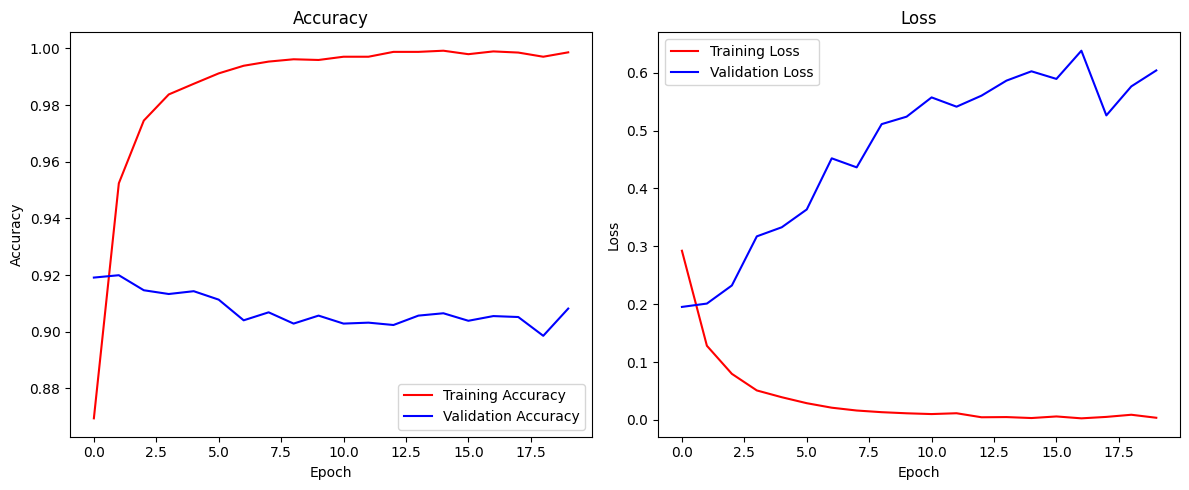

In [14]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="red")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()  
plt.show()

In [15]:
y_bid=bid.predict(X_test)
y_bid = (y_bid>0.5).astype(int)

2023-10-30 18:35:13.979977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:35:14.091389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:35:14.108526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 3s 11ms/step


In [22]:
accuracy_score(y_test,y_bid)

0.9101905550952776

In [23]:
confusion_matrix(y_test,y_bid)

array([[3118,  301],
       [ 241, 2375]])

In [26]:
print(classification_report(y_test,y_bid))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3419
           1       0.89      0.91      0.90      2616

    accuracy                           0.91      6035
   macro avg       0.91      0.91      0.91      6035
weighted avg       0.91      0.91      0.91      6035

